In [1]:
import torch.onnx
import torchvision
import torch
import numpy as np
from torch.autograd import Variable
from model_thermal_rgb import Discriminator, Generator
from model import Generator as VaillaSRGAN
from config import Config
from thermal_dataset import ThermalImageDataset as ImageDataset
from thermal_dataset import calc_temp
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import scipy.misc
from torchvision.utils import save_image
import torch.nn.functional as F

/home/lion397/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def add_colorbar(im,ax):
    # OFF AXX
    ax.axis("off")

    colorbar = plt.colorbar(im, ax=ax)
    # # Adjust the size and position of the colorbar
    pad = 0.005  # Distance between the image and colorbar
    width = 0.1 # Width of the colorbar
    # colorbar.ax.set_aspect(30)  # Adjust the aspect ratio of the colorbar
    colorbar.ax.set_position([ax.get_position().x1 + pad, ax.get_position().y0, width, ax.get_position().height])

    # Adjust the thickness of the gray bar
    #colorbar.ax.tick_params(width=2)  # Increase the linewidth of the tick marks
    #colorbar.outline.set_linewidth(2)  # Increase the linewidth of the colorbar outline

def move_image(input, x,y, border=cv2.BORDER_CONSTANT):
    pad_x = abs(x)
    pad_y = abs(y)
    shape = input.shape
    if len(shape) == 3:
        # Permute
        output = input.transpose(1,2,0)
        shape = output.shape
        output = cv2.copyMakeBorder(output, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1],:]
        output = output.transpose(2,0,1)

    else:
        output = cv2.copyMakeBorder(input, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1]]

    return output

def move_tensor(input, x,y, border=cv2.BORDER_CONSTANT):
    orig_shape = input.shape
    np_image = input.squeeze().numpy()
    temp = move_image(np_image,x,y,border=border)

    return torch.FloatTensor(temp.reshape(orig_shape))

@torch.no_grad()
def matchTemplateTorch(img, template):
    img_tensor = torch.from_numpy(img).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    template_tensor = torch.from_numpy(template).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    result = matchTemplateTorchCore(img_tensor, template_tensor)
    return result.cpu().numpy()

@torch.jit.script    
def matchTemplateTorchCore(img_tensor, template_tensor):
    result1 = torch.nn.functional.conv2d(img_tensor, template_tensor, bias=None, stride=1, padding=0)
    result2 = torch.sqrt(torch.sum(template_tensor**2) * torch.nn.functional.conv2d(img_tensor**2, torch.ones_like(template_tensor), bias=None, stride=1, padding=0))

    return (result1/result2).squeeze(0).squeeze(0)
    #return (result1).squeeze(0).squeeze(0)
   
def matchTemplateThetaBatch(background, template):
    batch_size = background.shape[0]
    theta = torch.zeros(batch_size, 6).to(background.device)

    for i in range(batch_size):
        template_i = template[i].unsqueeze(0)
        # Stretch template from 0 to 1
        template_i = (template_i - torch.min(template_i)) / (torch.max(template_i) - torch.min(template_i))
        
        background_i = F.interpolate(background[i].unsqueeze(0), size=(template_i.shape[-2], template_i.shape[-1]), mode='bilinear', align_corners=False)
        # Add padding to low img
        x_offset = background.shape[-2] // 4
        y_offset = background.shape[-1] // 4
        background_i = F.pad(background_i, (x_offset, x_offset, y_offset, y_offset), mode='replicate')
        res = matchTemplateTorchCore(background_i, template_i)
        result_max = torch.max(res)
        result_max_loc = torch.argmax(res)
        result_max_loc_x = result_max_loc % res.shape[0] 
        result_max_loc_y = result_max_loc // res.shape[1] 
        # print(result_max_loc_x, result_max_loc_y)

        # Make theta matrix from max location
        theta[i] = torch.tensor([1., 0., -2*(result_max_loc_x-x_offset)/ template.shape[-2], 0., 1., -2*(result_max_loc_y-y_offset) / template_i.shape[-1]])
        theta[i] = theta[i].unsqueeze(0).repeat(background_i.shape[0],1,1)

    return theta

In [3]:
config = Config()
# config.device = torch.device("cpu", 0)
model = Generator(debug=True)
#model.load_state_dict(torch.load('results/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g-best.pth')) 
#model.load_state_dict(torch.load('results/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g-last.pth')) # Best visual reslt
#model.load_state_dict(torch.load('results/2023-06-01-ThermalRGB_HRMSE_RGBNCC_RealTemp/g-last.pth'))
#model.load_state_dict(torch.load('results/2023-06-01-ThermalRGB_HRMSE_RGBNCC_RealTemp/g-last.pth'))
# model.load_state_dict(torch.load('results/2023-06-02-ThermalRGB_HRMSE_HRNCC_RealTemp/g-best.pth'))
#model.load_state_dict(torch.load('results/2023-06-06-ThermalRGB_HRMSE_HRNCC_T4Data/g_epoch_1301.pth')) # New structure!
# model.load_state_dict(torch.load('results/2023-06-07-ThermalRGB_HRMSE_HRNCC_TIGAN/g-best.pth'))
#model.load_state_dict(torch.load('results/2023-06-23-CycleGANSR_Final_Training_T4_1_2_Detach/g-last.pth'))
model.load_state_dict(torch.load('results/2023-06-18-CycleGANSR_Final_Training_T4_1_2_3_Detach/g-last.pth'))
model.to(config.device)
model.eval()

model_VaillaSRGAN = VaillaSRGAN()
model_VaillaSRGAN.load_state_dict(torch.load('results/2023-06-23-VaillaSRGAN/g-best_srgan.pth')) 
model_VaillaSRGAN.to(config.device)
model_VaillaSRGAN.eval()


Generator(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (trunk): Sequential(
    (0): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

{'lr': [25.979937515258804, 51.23781250000002], 'hr': [29.488281250000043, 45.07578120231631]}


/home/lion397/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:4290: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


tensor([[1.0000, 0.0000, 0.0458, 0.0000, 1.0000, 0.0586]])


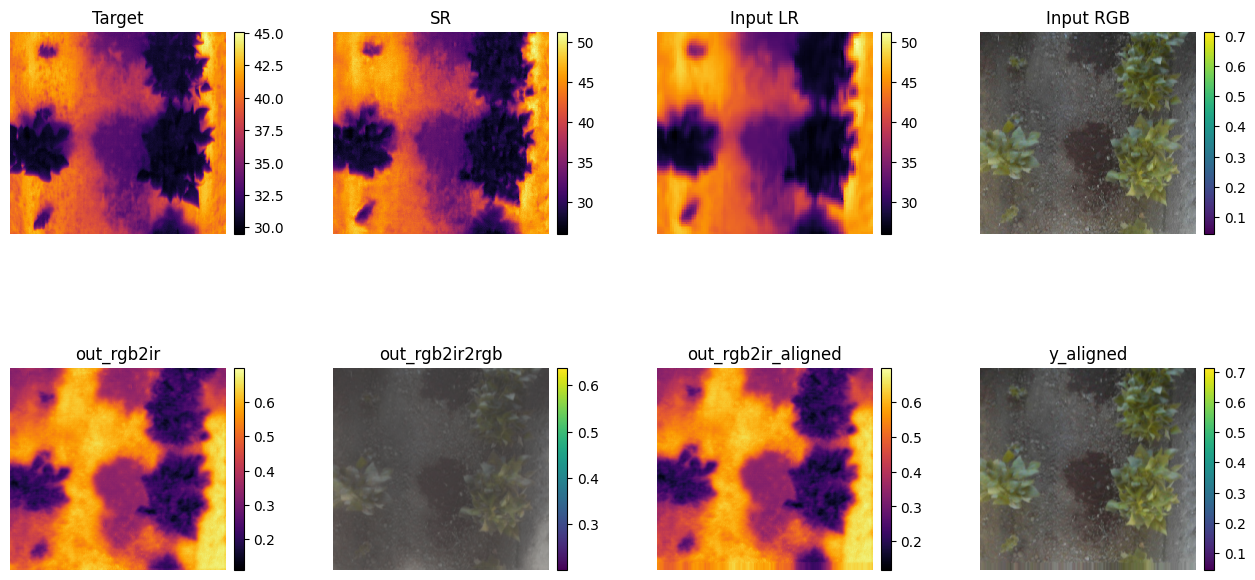

In [4]:
# Test Image
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val/",image_size=96, upscale_factor=4, mode="train")
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val",image_size=256, upscale_factor=4, mode="val")
#sample_dataset = ImageDataset(dataroot="/home/GEMINI/Dataset_processing/Davis_Legumes/2022-06-20/Thermal_Matched",image_size=96, upscale_factor=4, mode="val", random_crop=True)  
sample_dataset = ImageDataset(dataroot="/home/lion397/GEMINI/heesup/dataset/2022_T4/Training_T4_1_2_3/val",image_size=256, upscale_factor=4, mode="val", random_crop=False)
#sample_dataset = ImageDataset(dataroot="/home/lion397/GEMINI/heesup/dataset/Training_All_221201/train",image_size=256, upscale_factor=4, mode="val", random_crop=True)  
#sample_dataset = ImageDataset(dataroot="/home/lion397/GEMINI/heesup/dataset/pairs_processed",image_size=256, upscale_factor=4, mode="val", random_crop=True)  

(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[-70] # 늘 쓰던 Referene image
#rgb_img = move_tensor(rgb_img,0,20)
#rgb_img = torch.FloatTensor(np.zeros((3,256,256)))
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
print(thermal_info)
model.export_onnx = False
sr, debug = model(lr, rgb)
# print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
f, axarr = plt.subplots(2,4, figsize=(16,8))
high_img = calc_temp(high_img, thermal_info['hr'])
im0 = axarr[0][0].imshow(high_img, interpolation='none', cmap='inferno')
axarr[0][0].set_title("Target")
add_colorbar(im=im0,ax=axarr[0][0])
sr_img = calc_temp(sr_img, thermal_info['lr'])
im1 = axarr[0][1].imshow(sr_img, interpolation='none', cmap='inferno')
axarr[0][1].set_title("SR")
add_colorbar(im=im1,ax=axarr[0][1])
lr_img = calc_temp(lr_img, thermal_info['lr'])
im2 = axarr[0][2].imshow(lr_img, interpolation='none', cmap='inferno')
axarr[0][2].set_title("Input LR")
add_colorbar(im=im2,ax=axarr[0][2])
im3 = axarr[0][3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[0][3].set_title("Input RGB")
add_colorbar(im=im3,ax=axarr[0][3])
axarr[0][3].axis("off")

im3 = axarr[1][0].imshow(model.out_rgb2ir.squeeze().cpu().detach().numpy(), cmap='inferno')
axarr[1][0].set_title("out_rgb2ir")
add_colorbar(im=im3,ax=axarr[1][0])
axarr[1][0].axis("off")


template = model.out_rgb2ir.to('cpu', non_blocking=True)
lr_resized = F.interpolate(lr, size=(template.shape[-2], template.shape[-1]), mode='bilinear', align_corners=False).to('cpu', non_blocking=True)
theta = matchTemplateThetaBatch(lr_resized, template)
resampling_grid = F.affine_grid(theta.view(-1, 2, 3), template.size())
template_aligned = F.grid_sample(template, resampling_grid, mode='bilinear', padding_mode='border', align_corners=False) # 'zeros', 'border', or 'reflection'
print(theta)

# im3 = axarr[5].imshow(template_aligned.squeeze().cpu().detach().numpy(), cmap='inferno',vmin=0,vmax=1)
# axarr[5].set_title("template_aligned")
# add_colorbar(im=im3,ax=axarr[5])
# axarr[5].axis("off")

rgb_img_disp = cv2.cvtColor(model.out_rgb2ir2rgb.squeeze().permute(1,2,0).cpu().detach().numpy(),cv2.COLOR_RGB2BGR)
im3 = axarr[1][1].imshow(rgb_img_disp)
axarr[1][1].set_title("out_rgb2ir2rgb")
add_colorbar(im=im3,ax=axarr[1][1])
axarr[1][1].axis("off")



im3 = axarr[1][2].imshow(model.out_rgb2ir_aligned.squeeze().cpu().detach().numpy(), cmap='inferno')
axarr[1][2].set_title("out_rgb2ir_aligned")
add_colorbar(im=im3,ax=axarr[1][2])
axarr[1][2].axis("off")

rgb_img_disp = cv2.cvtColor(model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy(),cv2.COLOR_RGB2BGR)
im3 = axarr[1][3].imshow(rgb_img_disp)
axarr[1][3].set_title("y_aligned")
add_colorbar(im=im3,ax=axarr[1][3])
axarr[1][3].axis("off")

plt.show()

{'lr': [25.979937515258804, 51.23781250000002], 'hr': [29.488281250000043, 45.07578120231631]}
{'lr': [25.979937515258804, 51.23781250000002], 'hr': [29.488281250000043, 45.07578120231631]}


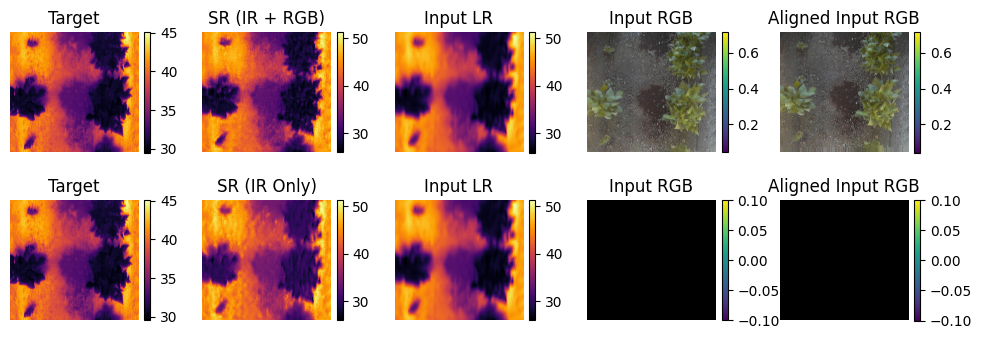

In [5]:
f, axarr = plt.subplots(2,5, figsize=(12,4))
cmap = 'inferno'
######################
# Test Image
rgb_img2 = move_tensor(rgb_img,0,0)
#rgb_img2 = torch.FloatTensor(np.zeros((3,256,256)))
# Random noise of 3, 256,256
#rgb_img2 = torch.FloatTensor(np.random.rand(3,256,256))

#rgb_img2 = rgb_img
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img2.unsqueeze(0).to(config.device, non_blocking=True)
rgb_img_disp = rgb_img2.permute(1,2,0).cpu().detach().numpy()
print(thermal_info)
model.export_onnx = False
sr,_ = model(lr, rgb)
#print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
high_img = calc_temp(high_img, thermal_info['hr'])
im0 = axarr[0][0].imshow(high_img, interpolation='none', cmap=cmap)
axarr[0][0].set_title("Target")
add_colorbar(im=im0,ax=axarr[0][0])
sr_img = calc_temp(sr_img, thermal_info['lr'])
im1 = axarr[0][1].imshow(sr_img, interpolation='none', cmap=cmap)
axarr[0][1].set_title("SR (IR + RGB)")
add_colorbar(im=im1,ax=axarr[0][1])
lr_img = calc_temp(lr_img, thermal_info['lr'])
im2 = axarr[0][2].imshow(lr_img, interpolation='none', cmap=cmap)
axarr[0][2].set_title("Input LR")
add_colorbar(im=im2,ax=axarr[0][2])
im3 = axarr[0][3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[0][3].set_title("Input RGB")
add_colorbar(im=im3,ax=axarr[0][3])
axarr[0][3].axis("off")

im3 = axarr[0][4].imshow(cv2.cvtColor(model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy(),cv2.COLOR_RGB2BGR),interpolation='none')
axarr[0][4].set_title("Aligned Input RGB")
add_colorbar(im=im3,ax=axarr[0][4])
axarr[0][4].axis("off")

######################
#rgb_img2 = move_tensor(rgb_img,0,0)
rgb_img2 = torch.FloatTensor(np.zeros((rgb.shape))).squeeze()
# Random noise of 3, 256,256
#rgb_img2 = torch.FloatTensor(np.random.rand(3,256,256))

#rgb_img2 = rgb_img
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img2.unsqueeze(0).to(config.device, non_blocking=True)
rgb_img_disp = rgb_img2.permute(1,2,0).cpu().detach().numpy()
print(thermal_info)
model.export_onnx = True
sr,_ = model(lr, rgb)
#print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
high_img = calc_temp(high_img, thermal_info['hr'])
im0 = axarr[1][0].imshow(high_img, interpolation='none', cmap=cmap)
axarr[1][0].set_title("Target")
add_colorbar(im=im0,ax=axarr[1][0])
sr_img = calc_temp(sr_img, thermal_info['lr'])
im1 = axarr[1][1].imshow(sr_img, interpolation='none', cmap=cmap)
axarr[1][1].set_title("SR (IR Only)")
add_colorbar(im=im1,ax=axarr[1][1])
lr_img = calc_temp(lr_img, thermal_info['lr'])
im2 = axarr[1][2].imshow(lr_img, interpolation='none', cmap=cmap)
axarr[1][2].set_title("Input LR")
add_colorbar(im=im2,ax=axarr[1][2])
im3 = axarr[1][3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[1][3].set_title("Input RGB")
add_colorbar(im=im3,ax=axarr[1][3])
axarr[1][3].axis("off")

im3 = axarr[1][4].imshow(cv2.cvtColor(model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy(),cv2.COLOR_RGB2BGR),interpolation='none')
axarr[1][4].set_title("Aligned Input RGB")
add_colorbar(im=im3,ax=axarr[1][4])
axarr[1][4].axis("off")

plt.show()

In [6]:
ids = np.linspace(0,len(sample_dataset)-1,4,dtype=np.int32)
print(ids)


[  0 217 434 652]


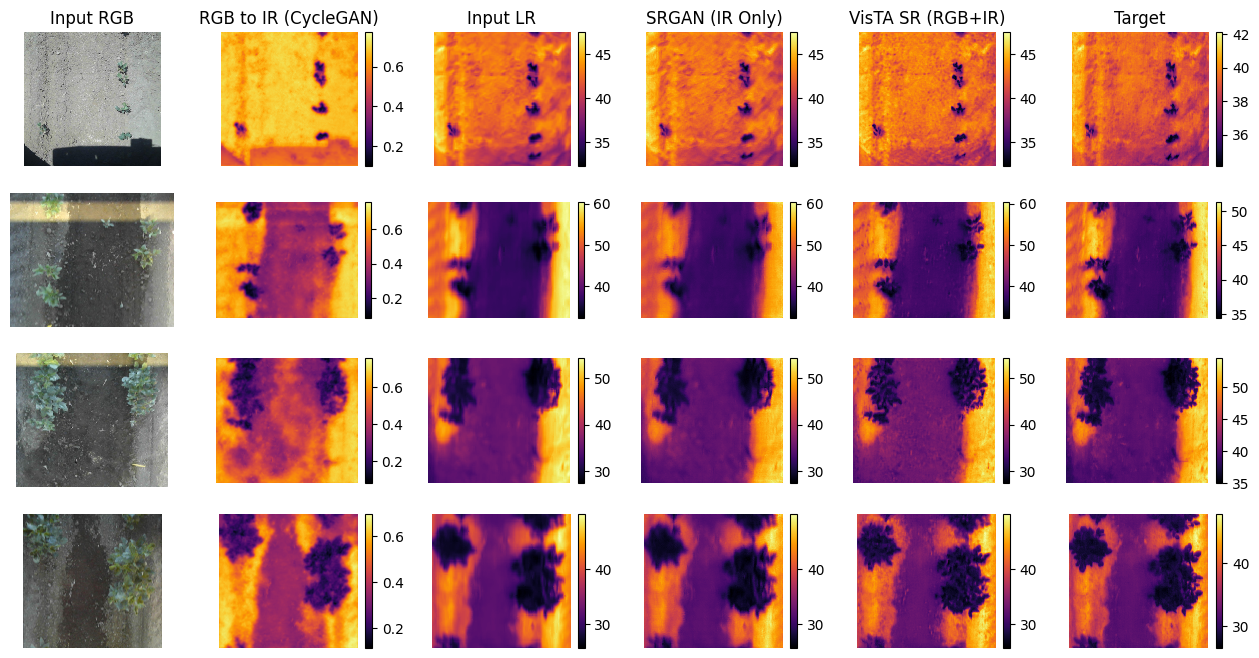

In [8]:
# Create a 4 row plot
# 434 => not matched LR and HR
#ids = [0, 130, 131,140]
ids = [0, 140, 130, 217]
#ids = np.linspace(0,len(sample_dataset)-1,4,dtype=np.int32)

f, axarr = plt.subplots(len(ids),6, figsize=(16,8))
for i,img_id in enumerate(ids):
    (low_img, rgb_img, high_ir, thermal_info) = sample_dataset[img_id]
    high_img = high_ir.squeeze()
    lr_img = low_img.squeeze()
    lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
    rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)

    model.export_onnx = False
    sr, debug = model(lr, rgb)
    
    rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
    rgb2ir_disp = model.out_rgb2ir.squeeze().cpu().detach().numpy()

    sr_img = sr.squeeze().cpu().detach().numpy()
    lr_img = lr.squeeze().cpu().detach().numpy()
    high_img = high_ir.squeeze().cpu().detach().numpy()

    # print(model.stn.dtheta)
    if 0:
        model.export_onnx = True
        sr_norgb, _ = model(lr, torch.FloatTensor(np.zeros((rgb.shape))).to(config.device, non_blocking=True))
        sr_norgb_img = sr_norgb.squeeze().cpu().detach().numpy()
    else:
        sr_norgb = model_VaillaSRGAN(lr)
        sr_norgb_img = sr_norgb.squeeze().cpu().detach().numpy()

    ax_ind = 0

    ax = axarr[i][ax_ind]
    im3 = ax.imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
    #im3 = ax.imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none', aspect='nearest')
    if i == 0:
        ax.set_title("Input RGB")
    # add_colorbar(im=im3,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    im3 = ax.imshow(rgb2ir_disp, cmap='inferno')
    if i == 0:
        ax.set_title("RGB to IR (CycleGAN)")
    add_colorbar(im=im3,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    lr_img = calc_temp(lr_img, thermal_info['lr'])
    im2 = ax.imshow(lr_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("Input LR")
    add_colorbar(im=im2,ax=ax)
    ax_ind += 1

    ax = axarr[i][ax_ind]
    sr_norgb_img = calc_temp(sr_norgb_img, thermal_info['lr'])
    im2 = ax.imshow(sr_norgb_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("SRGAN (IR Only)")
    add_colorbar(im=im2,ax=ax)
    ax_ind += 1

    ax = axarr[i][ax_ind]
    sr_img = calc_temp(sr_img, thermal_info['lr'])
    im1 = ax.imshow(sr_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("VisTA SR (RGB+IR)")
    add_colorbar(im=im1,ax=ax)
    ax_ind += 1

    ax = axarr[i][ax_ind]
    high_img = calc_temp(high_img, thermal_info['hr'])
    im0 = ax.imshow(high_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("Target")
    add_colorbar(im=im0,ax=ax)
    ax_ind += 1

/home/lion397/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:4290: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


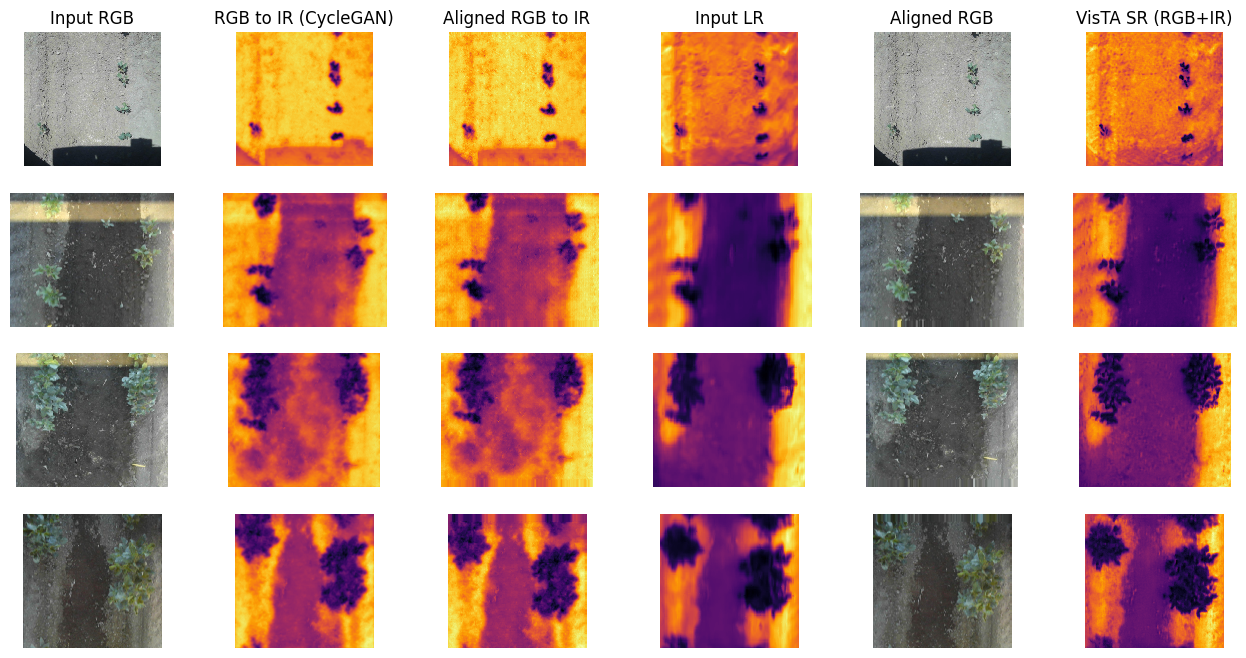

In [17]:
# Create a 4 row plot
# 434 => not matched LR and HR
#ids = [0, 130, 131,140]
ids = [0, 140, 130, 217]
#ids = np.linspace(0,len(sample_dataset)-1,4,dtype=np.int32)

f, axarr = plt.subplots(len(ids),6, figsize=(16,8))
for i,img_id in enumerate(ids):
    (low_img, rgb_img, high_ir, thermal_info) = sample_dataset[img_id]
    high_img = high_ir.squeeze()
    lr_img = low_img.squeeze()
    lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
    rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)

    model.export_onnx = False
    sr, debug = model(lr, rgb)
    
    rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
    rgb2ir_disp = model.out_rgb2ir.squeeze().cpu().detach().numpy()
    rgb_aligned_disp = model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy()
    # print(model.stn.dtheta)
    sr_img = sr.squeeze().cpu().detach().numpy()
    lr_img = lr.squeeze().cpu().detach().numpy()
    high_img = high_ir.squeeze().cpu().detach().numpy()

    ax_ind = 0 

    ax = axarr[i][ax_ind]
    im3 = ax.imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
    if i == 0:
        ax.set_title("Input RGB")
    # add_colorbar(im=im3,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    im3 = ax.imshow(rgb2ir_disp, cmap='inferno')
    if i == 0:
        ax.set_title("RGB to IR (CycleGAN)")
    # add_colorbar(im=im3,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    im2 = ax.imshow(model.out_rgb2ir_aligned.squeeze().cpu().detach().numpy(), interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("Aligned RGB to IR")
    # add_colorbar(im=im2,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    lr_img = calc_temp(lr_img, thermal_info['lr'])
    im2 = ax.imshow(lr_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("Input LR")
    # add_colorbar(im=im2,ax=ax)
    ax.axis("off")
    ax_ind += 1

    ax = axarr[i][ax_ind]
    im2 = ax.imshow(cv2.cvtColor(rgb_aligned_disp,cv2.COLOR_RGB2BGR), interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("Aligned RGB")
    # add_colorbar(im=im2,ax=ax)
    ax.axis("off")
    ax_ind += 1


    ax = axarr[i][ax_ind]
    sr_img = calc_temp(sr_img, thermal_info['lr'])
    im1 = ax.imshow(sr_img, interpolation='none', cmap='inferno')
    if i == 0:
        ax.set_title("VisTA SR (RGB+IR)")
    # add_colorbar(im=im1,ax=ax)
    ax.axis("off")
    ax_ind += 1

# Validate SR Result

Mean Distance (Filtered Matches): 222.88045974004837
Maximum Distance (Filtered Matches): 361.4899597167969


/home/lion397/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:4290: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


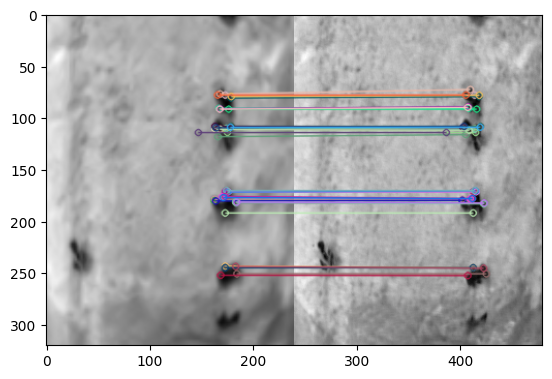

In [21]:
def normalize_img(img):
    max_val = np.max(img)
    min_val = np.min(img)

    return np.asarray((img-min_val) / (max_val - min_val)*255, dtype=np.uint8)


(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[0]
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)

model.export_onnx = False
sr, debug = model(lr, rgb)

rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
rgb2ir_disp = model.out_rgb2ir.squeeze().cpu().detach().numpy()
rgb_aligned_disp = model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy()

rgb_aligned_disp = cv2.cvtColor(rgb_aligned_disp,cv2.COLOR_BGR2RGB)

# print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
sr_img = calc_temp(sr_img, thermal_info['lr'])
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()

# Create SIFT object
orb = cv2.ORB_create()
#img_thermal_flir = normalize_img(thermal_vario)
image1 = normalize_img(cv2.resize(lr_img,dsize=(240,320)))
image2 = normalize_img(cv2.resize(sr_img,dsize=(240,320)))

# Detect keypoints and compute descriptors for the images
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Select good matches using RANSAC
src_pts = np.float32([keypoints1[match.queryIdx].pt for match in matches])
dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in matches])

# Apply RANSAC to estimate the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

# Filter the matches based on the RANSAC mask
filtered_matches = [match for i, match in enumerate(matches) if mask[i]]

# Calculate the mean and maximum distance of filtered matches
mean_distance = np.mean([match.distance for match in filtered_matches])
max_distance = max([match.distance for match in filtered_matches])

# Print the mean and maximum distance
print("Mean Distance (Filtered Matches):", mean_distance)
print("Maximum Distance (Filtered Matches):", max_distance)

# Draw the filtered matches
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, filtered_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_image)

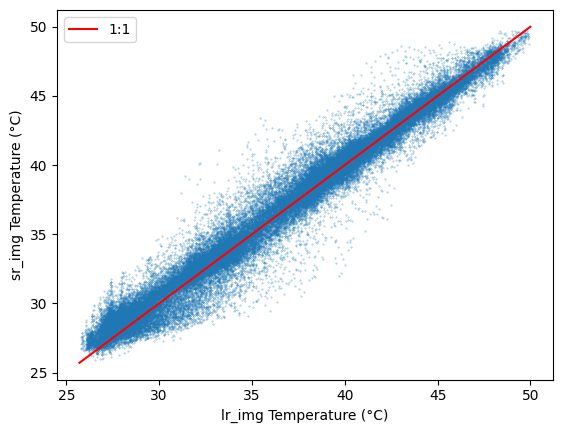

In [20]:
lr_img_resized = cv2.resize(lr_img,dsize=(240,320))
sr_img_resized = cv2.resize(sr_img,dsize=(240,320))
plt.scatter(lr_img_resized.reshape(-1),sr_img_resized.reshape(-1),marker=".",alpha=0.5,s=0.5)

min_min = np.min([np.min(lr_img), np.min(sr_img)])
max_max = np.max([np.max(lr_img), np.max(sr_img)])
# Add 1:1 line
plt.plot([min_min, max_max], 
         [min_min, max_max], color='red',label=f"1:1")

plt.xlabel("lr_img Temperature (°C)")
plt.ylabel("sr_img Temperature (°C)")
# Show the plot
# plt.title("100x100")
plt.legend()
plt.show()

# Thermal RGB Indexes

In [ ]:
def calculate_exg(image):
    # Convert the image to float32
    image = image.astype(np.float32)
    
    # Split the image into individual color channels
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    
    # Calculate the ExG index
    exg = (2 * g - r - b) / (2 * g + r + b)
    
    return exg

def create_binary_mask(exg_image, min_threshold=None,max_threshold=None):
    # Create an empty mask with the same shape as the ExG image
    mask = np.zeros_like(exg_image, dtype=np.uint8)
    
    # Apply the threshold to create the binary mask
    if min_threshold and max_threshold:
        mask[exg_image > min_threshold and exg_image < max_threshold] = 1
    elif max_threshold:
        mask[exg_image < max_threshold] = 1
    elif min_threshold:
        mask[exg_image > min_threshold] = 1

    return mask
(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[0]
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)

model.export_onnx = False
sr, debug = model(lr, rgb)

rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
rgb2ir_disp = model.out_rgb2ir.squeeze().cpu().detach().numpy()
rgb_aligned_disp = model.y_aligned.squeeze().permute(1,2,0).cpu().detach().numpy()

rgb_aligned_disp = cv2.cvtColor(rgb_aligned_disp,cv2.COLOR_BGR2RGB)

# print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
sr_img = calc_temp(sr_img, thermal_info['lr'])
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()

# Test
exg_image = calculate_exg(rgb_aligned_disp)

plt.subplot(161)
plt.imshow(rgb_aligned_disp)
plt.colorbar()

plt.subplot(162)
plt.imshow(exg_image)
plt.colorbar()

plt.subplot(163)
plt.imshow(sr_img)
plt.colorbar()

plt.subplot(164)
sr_img_mask = sr_img < 30
plt.imshow(exg_image*sr_img_mask)
plt.colorbar()

plt.subplot(165)
exg_image_mask = create_binary_mask(exg_image,0.05)
plt.imshow(exg_image_mask,interpolation=None)
plt.colorbar()

plt.subplot(166)
plt.imshow(exg_image_mask*sr_img,interpolation=None)
plt.colorbar()

: 

In [ ]:
def merge_adjacent_boxes(bounding_boxes, threshold=0.5):
    merged_boxes = []
    visited = [False] * len(bounding_boxes)

    for i in range(len(bounding_boxes)):
        if visited[i]:
            continue

        x1, y1, w1, h1 = bounding_boxes[i]
        merged_box = [x1, y1, w1, h1]
        visited[i] = True

        for j in range(i + 1, len(bounding_boxes)):
            if visited[j]:
                continue

            x2, y2, w2, h2 = bounding_boxes[j]
            if calculate_overlap(merged_box, [x2, y2, w2, h2]) >= threshold:
                merged_box = merge_boxes(merged_box, [x2, y2, w2, h2])
                visited[j] = True

        merged_boxes.append(merged_box)

    return merged_boxes

def calculate_overlap(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_area = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    
    #union_area = w1 * h1 + w2 * h2 - intersection_area
    #return intersection_area / union_area

    min_area = min(w1 * h1,w2 * h2 )
    return intersection_area / min_area

def merge_boxes(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y

    return [x, y, w, h]

: 

In [ ]:
#exg_image_mask = create_binary_mask(exg_image,0.07)
image_mask = create_binary_mask(sr_img,max_threshold=35)
#image_mask = create_binary_mask(ndvi,min_threshold=0.3)
if cv2.__version__.startswith('3.'):
        # OpenCV 3.x syntax
        _, contours, _ = cv2.findContours(image_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
else:
    # OpenCV 4.x syntax
    contours, _ = cv2.findContours(image_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


# draw contours on the original image
#image_copy = rgb_aligned_disp.copy()
image_copy = rgb_aligned_disp.copy()
#cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

# Assuming you have a list of contours called "contours"
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, w, h))

def sort_bounding_boxes_by_area(bounding_boxes):
    sorted_boxes = sorted(bounding_boxes, key=lambda box: box[2] * box[3], reverse=True)
    return sorted_boxes

# Assuming you have a list of bounding boxes called "bounding_boxes"
sorted_boxes = sort_bounding_boxes_by_area(bounding_boxes)
bounding_boxes = merge_adjacent_boxes(sorted_boxes,0.01)

# Print the bounding box coordinates
for bbox in bounding_boxes:
    x, y, w, h = bbox
    if w*h > 40:
        # print(f"Bounding box: x={x}, y={y}, width={w}, height={h}")
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Get 

plt.imshow(image_copy,cmap='gray')

: 

In [ ]:
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print("Number of Contours found = " + str(len(contours)))
  
# Draw all contours
# -1 signifies drawing all contours
cv2.drawContours(exg_image, contours, -1, (0, 255, 0), 3)

plt.imshow(exg_image,interpolation=None,cmap='gray')

plt.colorbar()

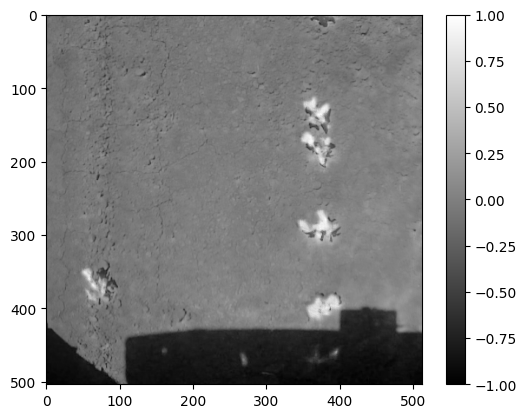

In [54]:
def calculate_ndvi(thermal_image, rgb_image):
    # Convert the thermal image to floating-point values
    thermal_image = thermal_image.astype(np.float32)
    

    
    # Convert the RGB image to floating-point values
    rgb_image = rgb_image.astype(np.float32)
    
    # Calculate the NDVI
    nir_band = thermal_image
    red_band = rgb_image[:, :, 1]  # Assuming red band is in the first channel of the RGB image
    
    # Normalize the thermal image values between 0 and 1
    red_band = (red_band - np.min(red_band)) / (np.max(red_band) - np.min(red_band))
    # Normalize the thermal image values between 0 and 1
    nir_band = (nir_band - np.min(nir_band)) / (np.max(nir_band) - np.min(nir_band))

    ndvi = (red_band-nir_band) / (nir_band + red_band)
    if 0:
        # Apply the thermal image as a mask to remove non-vegetation areas
        ndvi = np.where(thermal_image_normalized > 0.5, ndvi, 0)
    
    return ndvi

ndvi = calculate_ndvi(sr_img,rgb_img_disp)
plt.imshow(ndvi,cmap='gray')
plt.colorbar()

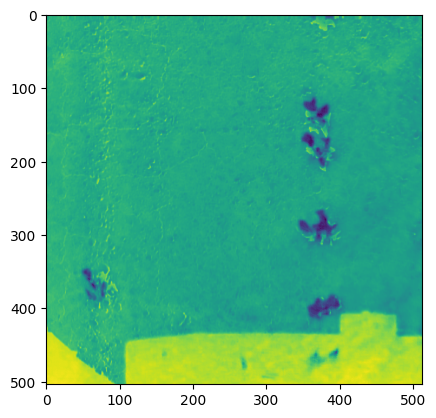

In [61]:
ndvi = calculate_ndvi(sr_img,rgb_aligned_disp)
plt.imshow(ndvi)

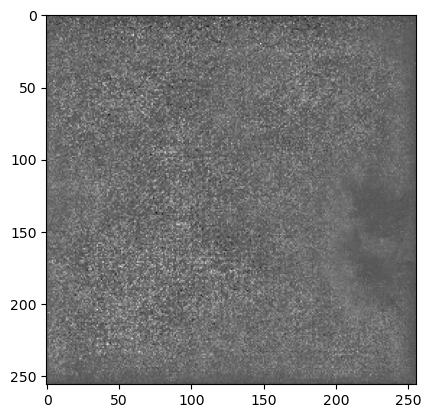

In [26]:
feature = debug[2].squeeze().cpu().detach().numpy()
plt.imshow(feature[2,:,:], cmap='gray')

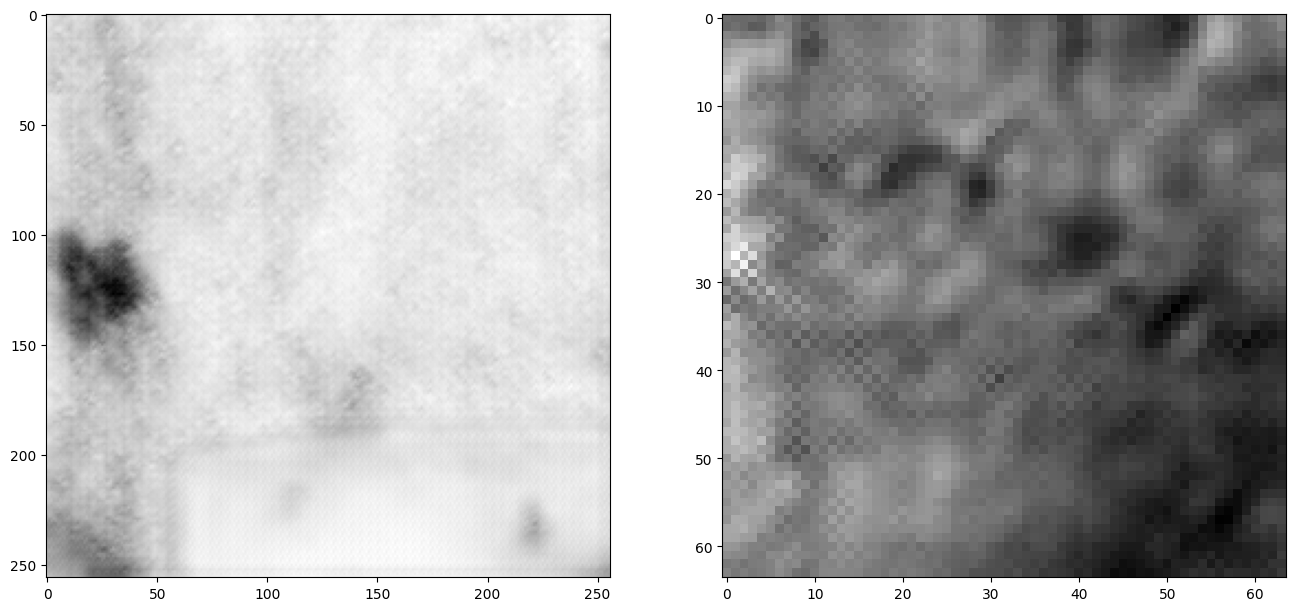

In [7]:
# Make 1x2 subplot
f, axarr = plt.subplots(1,2, figsize=(16,8))
feature = torch.mean(torch.abs(debug[0]),dim=1).squeeze().cpu().detach().numpy()
axarr[0].imshow(feature, cmap='gray')
feature = torch.mean(torch.abs(debug[1]),dim=1).squeeze().cpu().detach().numpy()
axarr[1].imshow(feature, cmap='gray')

In [94]:
# Debug RGB Features
feature = debug[1].squeeze().cpu().detach().numpy()
# Create 8x8 image patch using (64,64,64) feature images
# 1. Get 64x64x64 feature image
feature_img = np.zeros(shape=(64*8,64*8))
for i in range(64):
    feature_img[64*(i//8):64*(i//8+1),64*(i%8):64*(i%8+1)] = cv2.resize(feature[i,:,:],dsize=(64,64))
plt.imshow(feature_img, interpolation='none', cmap='gray')


IndexError: index 3 is out of bounds for axis 0 with size 3

tensor([[ 1.0000e+00,  0.0000e+00, -1.6251e-02,  0.0000e+00,  1.0000e+00,
         -5.8746e-04]], device='cuda:0', grad_fn=<AddBackward0>)


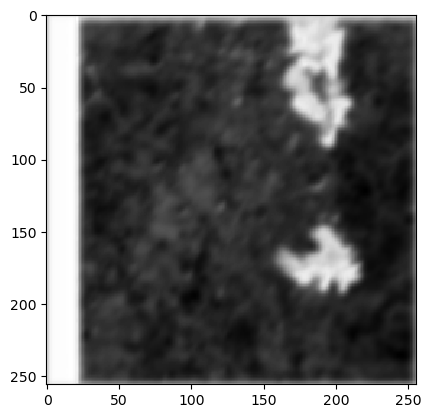

In [57]:

# Plot debug
print(model.stn.theta)
resampling_grid = F.affine_grid(
                    model.stn.theta.view(-1, 2, 3), debug[0].size())
warped_images = F.grid_sample(debug[0], resampling_grid, mode='bilinear', padding_mode='zeros', align_corners=False)
feature_img = warped_images.squeeze().cpu().detach().numpy()[0,:,:]
plt.imshow(feature_img, interpolation='none', cmap='gray')
# resampling_grid_img = resampling_grid.squeeze().cpu().detach().numpy()
# plt.imshow(resampling_grid_img[:,:,1], interpolation='none', cmap='gray')

In [70]:
def create_dir(dir_):
    os.makedirs(dir_, exist_ok = True)
    
def process_dataset(dataroot, prefix, debug = False, write_img = True):
    # dataroot = "../../../datasets/GEMINI/2022-02-22-Greenhouse/"

    sr_dataroot_save = os.path.join(dataroot,"IR_ThermalRGB")
    create_dir(sr_dataroot_save)

    sample_dataset = ImageDataset(dataroot=dataroot,
                                image_size=96, upscale_factor=4, mode="train")

    for i in tqdm(range(len(sample_dataset.low_filenames))):
        (low_img, rgb_img, high_ir) = sample_dataset.getImage(i)

        low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
        rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
        rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

        high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

        lr = low_img.to(config.device, non_blocking=True)
        rgb = rgb_img.to(config.device, non_blocking=True)
        high_ir = high_ir.to(config.device, non_blocking=True)

        sr = model(lr, rgb)

        sr_img = sr.squeeze().cpu().detach().numpy()
        lr_img = lr.squeeze().cpu().detach().numpy()
        high_img = high_ir.squeeze().cpu().detach().numpy()

        sr_name = '{prefix}_SR_480x640_{i:05d}.png'.format(prefix=prefix, i=i)

        if write_img:
            if 1:
                sr_img *= 255 # or any coefficient
                sr_img = sr_img.astype(np.uint8)
                cv2.imwrite(os.path.join(sr_dataroot_save,sr_name), sr_img)
            else:
                save_image(sr,os.path.join(sr_img,sr_name))

process_dataset(dataroot="/home/lion397/data/datasets/GEMINI/2022-04-05-Garbanzo/pairs_processed",prefix="220531_ThermalRGB",debug=False, write_img=True)

  0%|          | 0/170 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 160, 120, 3]

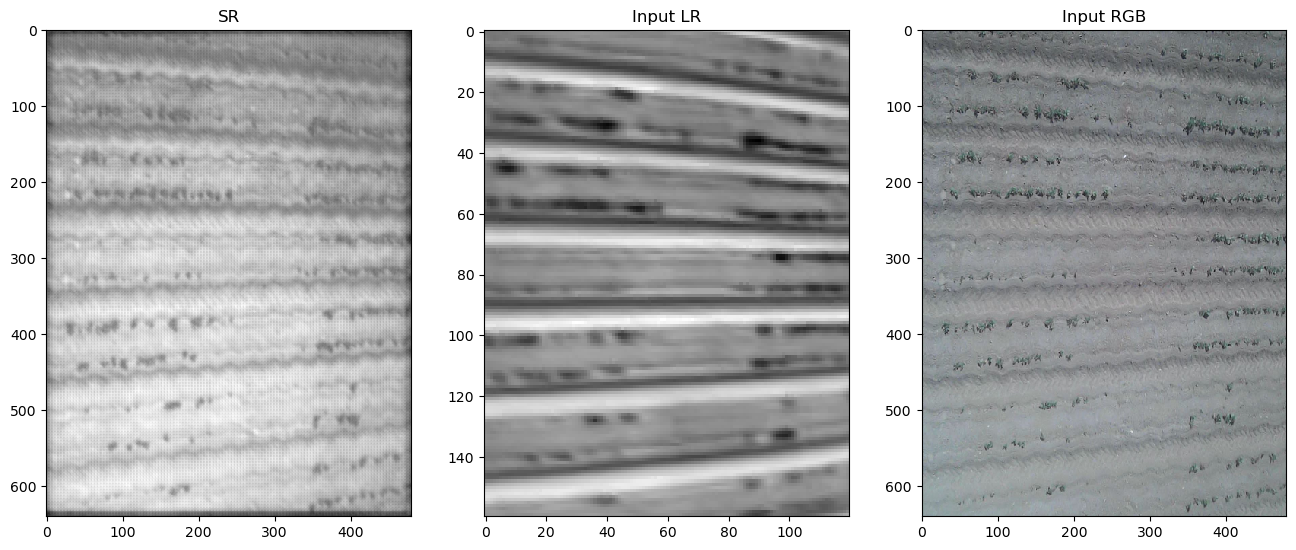

In [6]:
from tifffile import imsave, imread
# Test Image
rgb_img = cv2.imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/backup/flir_processed/220620_IMG_01570_RGB.jpg")
rgb_img = cv2.resize(rgb_img,dsize=(480,640))
low_img = imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/flir_processed/1_IR/220620_IMG_01570_IR.tiff") / 1000
low_img = cv2.resize(low_img, dsize=(rgb_img.shape[1]//4,rgb_img.shape[0]//4))

if 0:
    crop_bbox = [0,0,200,200]
    low_img = low_img[crop_bbox[0]//4:crop_bbox[2]//4,crop_bbox[1]//4:crop_bbox[3]//4]
    rgb_img = rgb_img[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]
    high_ir = high_ir[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]

rgb_img_disp = rgb_img
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0
#high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0
lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
#high_ir = high_ir.to(config.device, non_blocking=True)
sr = model(lr, rgb)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()

# plt.imshow(sr_img,cmap='gray')
f, axarr = plt.subplots(1,3, figsize=(16,8))
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[0].imshow(sr_img, interpolation='none', cmap='gray')
#im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[0].set_title("SR")
#plt.colorbar(im1, ax=axarr[1])
im2 = axarr[1].imshow(lr_img, interpolation='none', cmap='gray')
#im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray')
axarr[1].set_title("Input LR")
#plt.colorbar(im2, ax=axarr[2])
im3 = axarr[2].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[2].set_title("Input RGB")
#plt.colorbar(im3, ax=axarr[3])

plt.show()